In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Time series tools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
# Load CSV
data_path = Path("combined_NSW.csv")   # adjust path if needed
df = pd.read_csv(data_path)

print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Initial shape: (248594, 5)
Columns: ['REGION', 'SETTLEMENTDATE', 'TOTALDEMAND', 'RRP', 'PERIODTYPE']


,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,01-01-2018 00:30,6912.25,91.86,TRADE
1,NSW1,01-01-2018 01:00,6745.63,88.83,TRADE
2,NSW1,01-01-2018 01:30,6466.06,73.62,TRADE
3,NSW1,01-01-2018 02:00,6279.8,71.49,TRADE
4,NSW1,01-01-2018 02:30,6177.31,69.27,TRADE


In [ ]:
dt_col = "SETTLEMENTDATE"
value_col = "TOTALDEMAND"

# Convert datetime
df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")

# Clean numeric demand column
def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    x = str(x).replace(",", "").strip()
    import re
    x = re.sub(r"[^0-9.\-]", "", x)
    try:
        return float(x)
    except:
        return np.nan

df[value_col] = df[value_col].apply(clean_numeric)

# Drop rows with missing datetime or demand
df = df.dropna(subset=[dt_col, value_col])

# Set datetime index
df = df.set_index(dt_col).sort_index()

print("After cleaning:", df.shape)
df.describe()


After cleaning: (98495, 4)


,TOTALDEMAND
count,98495.000000
mean,7574.084736
std,1253.271372
min,3957.320000
25%,6648.910000
50%,7447.330000
75%,8308.590000
max,13634.630000


In [ ]:
# Keep only demand column for analysis
series = df[[value_col]].copy()

# Resample to 30-min frequency
series = series.resample("30T").mean()

# Fill gaps: interpolate, then forward/back fill
series[value_col] = series[value_col].interpolate(method="time").ffill().bfill()

print("Missing after cleaning:", series[value_col].isna().sum())
series.head()


Missing after cleaning: 0


,TOTALDEMAND
SETTLEMENTDATE,
2018-01-01 00:30:00,6912.25
2018-01-01 01:00:00,6745.63
2018-01-01 01:30:00,6466.06
2018-01-01 02:00:00,6279.80
2018-01-01 02:30:00,6177.31


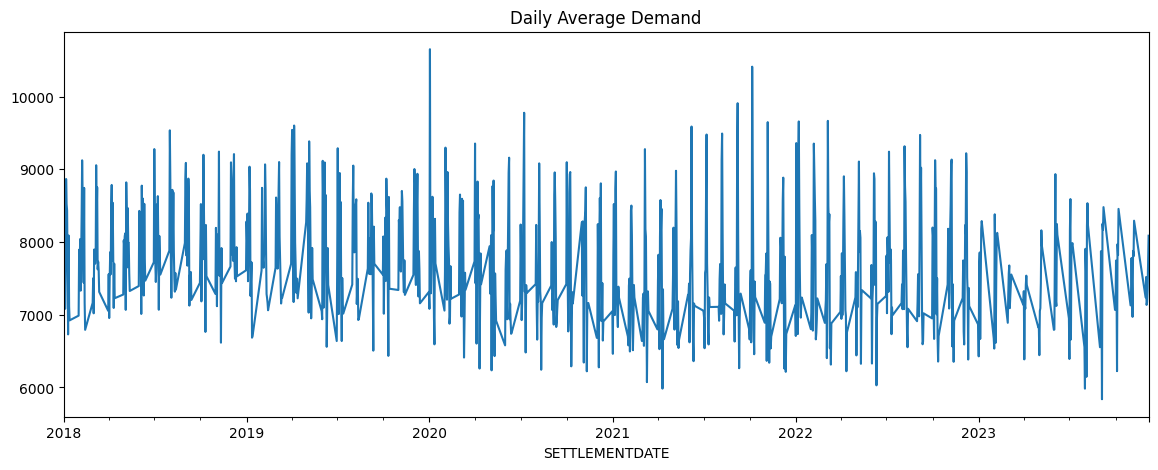

In [ ]:
# Plot daily average
series[value_col].resample("D").mean().plot(figsize=(14,5), title="Daily Average Demand")
plt.show()


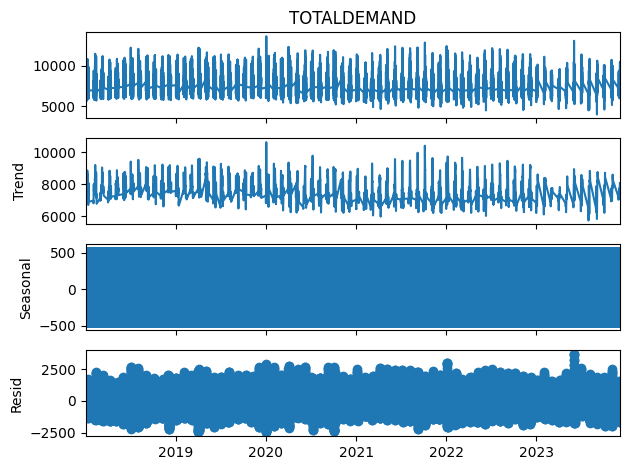

In [ ]:
# Seasonal decomposition (daily = 48 half-hours)
result = seasonal_decompose(series[value_col], model="additive", period=48)
result.plot()
plt.show()


In [ ]:
# ADF test (stationarity)
series_clean = series[value_col].replace([np.inf, -np.inf], np.nan).dropna()
adf = adfuller(series_clean)
print("ADF Statistic:", adf[0])
print("p-value:", adf[1])


ADF Statistic: -23.822907950053757
p-value: 0.0


In [ ]:
# ADF test (stationarity)
series_clean = series[value_col].replace([np.inf, -np.inf], np.nan).dropna()
adf = adfuller(series_clean)
print("ADF Statistic:", adf[0])
print("p-value:", adf[1])


ADF Statistic: -23.822907950053757
p-value: 0.0


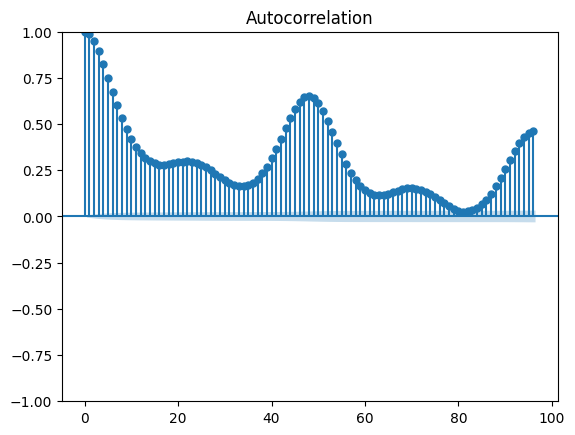

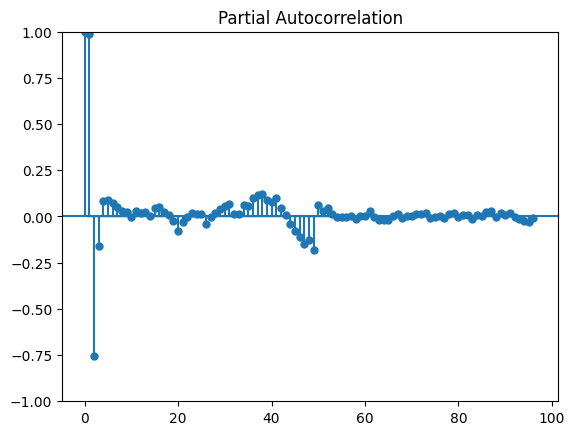

In [ ]:
# ACF & PACF
plot_acf(series_clean, lags=96)
plt.show()

plot_pacf(series_clean, lags=96, method="ywm")
plt.show()


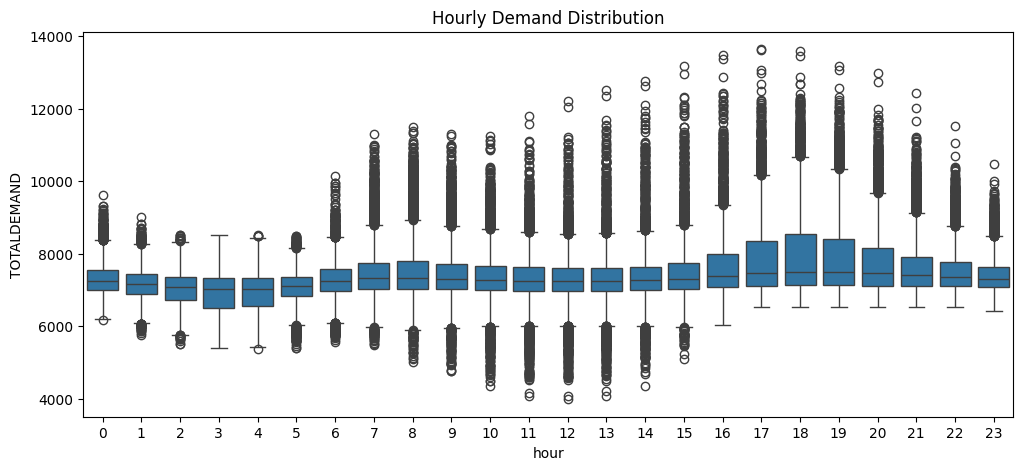

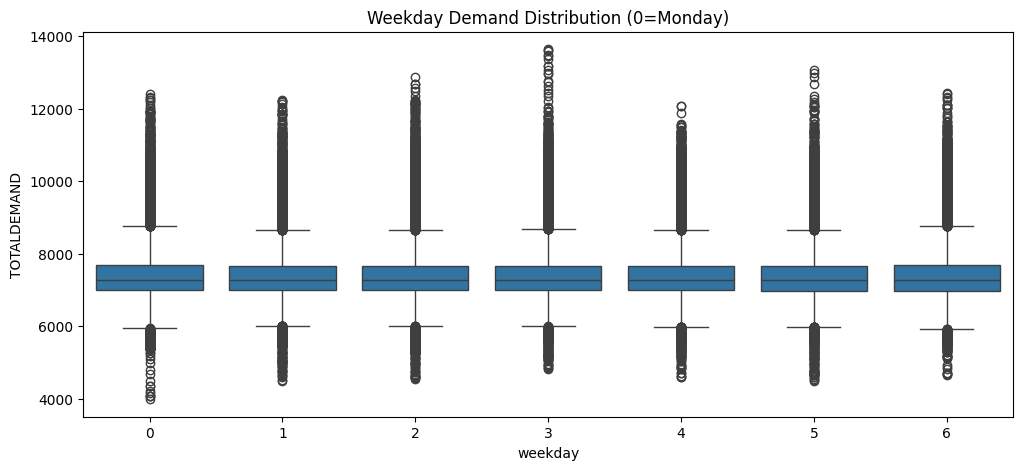

In [ ]:
# Boxplots
df_box = series.copy()
df_box["hour"] = df_box.index.hour
df_box["weekday"] = df_box.index.dayofweek

plt.figure(figsize=(12,5))
sns.boxplot(x="hour", y=value_col, data=df_box)
plt.title("Hourly Demand Distribution")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x="weekday", y=value_col, data=df_box)
plt.title("Weekday Demand Distribution (0=Monday)")
plt.show()


In [ ]:
h = 7 * 48   # 7 days horizon (336 half-hours)

train = series[value_col].iloc[:-h]
test = series[value_col].iloc[-h:]

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (103631,)
Test size: (336,)


In [ ]:
def mae_rmse(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))   # take sqrt manually
    return mae, rmse


In [ ]:
results = []

# Naive
naive_pred = np.repeat(train.iloc[-1], len(test))
results.append(("Naive",) + mae_rmse(test, naive_pred))

# Seasonal Naive
season_len = 48
sn_pred = np.tile(train.iloc[-season_len:], int(np.ceil(len(test)/season_len)))[:len(test)]
results.append(("SeasonalNaive",) + mae_rmse(test, sn_pred))

# Holt-Winters
hw = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=season_len)
hw_fit = hw.fit()
hw_fore = hw_fit.forecast(len(test))
results.append(("HoltWinters",) + mae_rmse(test, hw_fore))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
best_model = None
best_aic = np.inf

for p in range(2):
    for d in range(2):
        for q in range(2):
            try:
                model = SARIMAX(train, order=(p,d,q))
                fit = model.fit(disp=False)
                if fit.aic < best_aic:
                    best_aic = fit.aic
                    best_model = fit
            except:
                continue


if best_model:
    sar_fore = best_model.get_forecast(len(test)).predicted_mean
    results.append(("SARIMAX",) + mae_rmse(test, sar_fore))


In [ ]:
def make_features(series, lags=48):
    df_feat = pd.DataFrame({"y": series})
    for lag in range(1, lags+1):
        df_feat[f"lag_{lag}"] = df_feat["y"].shift(lag)
    df_feat["hour"] = df_feat.index.hour
    df_feat["weekday"] = df_feat.index.dayofweek
    df_feat["month"] = df_feat.index.month
    df_feat = df_feat.dropna()
    return df_feat

lags = 48
feat = make_features(series[value_col], lags)
X, y = feat.drop(columns=["y"]), feat["y"]

train_X = X.loc[train.index.intersection(X.index)]
train_y = y.loc[train.index.intersection(y.index)]
test_X = X.loc[test.index.intersection(X.index)]
test_y = y.loc[test.index.intersection(y.index)]


In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(train_X, train_y)
rf_pred = rf.predict(test_X)
results.append(("RandomForest",) + mae_rmse(test_y, rf_pred))


In [ ]:
# Gradient Boosting
gb = GradientBoostingRegr
essor(n_estimators=200, random_state=42)
gb.fit(train_X, train_y)
gb_pred = gb.predict(test_X)
results.append(("GradientBoosting",) + mae_rmse(test_y, gb_pred))


In [ ]:
res_df = pd.DataFrame(results, columns=["Model","MAE","RMSE"]).sort_values("MAE")
print(res_df)


              Model           MAE          RMSE
4      RandomForest     69.750515    107.338981
5  GradientBoosting     79.703212    124.537613
3           SARIMAX    696.708161    943.644952
0             Naive    697.134575    942.911646
1     SeasonalNaive    706.850416    945.195307
2       HoltWinters  23361.016612  26803.722858


In [ ]:
future_index = pd.date_range(series.index[-1] + pd.Timedelta(minutes=30), periods=h, freq="30T")

forecasts = pd.DataFrame(index=future_index)
forecasts["Naive"] = series[value_col].iloc[-1]
forecasts["SeasonalNaive"] = sn_pred[:h]
forecasts["HoltWinters"] = hw_fit.forecast(h).values

if best_model:
    forecasts["SARIMAX"] = best_model.get_forecast(h).predicted_mean.values

forecasts.head()


,Naive,SeasonalNaive,HoltWinters,SARIMAX
2023-12-07 00:00:00,8102.876667,7307.089412,7268.555283,7261.457250
2023-12-07 00:30:00,8102.876667,7306.134019,7241.622130,7260.885546
2023-12-07 01:00:00,8102.876667,7305.178625,7190.856565,7260.437005
2023-12-07 01:30:00,8102.876667,7304.223232,7122.866088,7260.085092
2023-12-07 02:00:00,8102.876667,7303.267839,7068.487009,7259.808991
